this script will build and deploy a model to perform crop type classification using random forest

In [ ]:
import ee

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

In [ ]:
# import packages
!pip install geemap
import geemap
import pandas as pd
import numpy as np
!pip install geopandas
import geopandas as gpd
%matplotlib inline 
import matplotlib.pyplot as plt

In [ ]:
# initialize geemap
geemap.ee_initialize()

In [ ]:
# define mapvariable
Map = geemap.Map()

In [ ]:
# import the data
in_csv1 = '/content/drive/MyDrive/MIZANI FIELDWORK DATA/githunguri_labeled_data.csv'


In [ ]:
# clean the data to remain with coordinates and crop type classification
# remove null values
df1 = geemap.csv_to_pandas(in_csv1)
df1 = df1.dropna()
df1.describe()

,X,Y,classification
count,712.000000,712.000000,712.000000
mean,36.699791,-1.069508,116.769663
std,0.010627,0.011487,64.547306
min,36.671702,-1.087277,2.000000
25%,36.692825,-1.079276,67.000000
50%,36.699712,-1.070806,113.000000
75%,36.708528,-1.061066,200.000000
max,36.736911,-1.024187,206.000000


In [ ]:
# sample first 5 features
df1.head()

,X,Y,classification,description
0,36.687597,-1.072014,206,Barren Land
1,36.688171,-1.071127,206,Barren Land
2,36.689757,-1.070010,206,Barren Land
3,36.684268,-1.071294,206,Barren Land
4,36.690655,-1.075949,206,Barren Land


In [ ]:
c_totals1 = df1.groupby("description")["classification"].count().sort_values()
c_totals1

description
Spinach                        1
Thorned Melon                  1
Calliandra                     1
Coriander                      1
Pumpkin                        2
Passion Fruit(Green)           2
Tree Tomato                    2
Exotic Chinese Vegetables      2
Courgette / Zucchini           2
Bay Leaves                     2
Cauliflower                    2
Red Radish                     3
Onions                         3
Avocado                        3
Corn maize                     5
Broccoli                       8
Potato                        12
Cabbage                       14
Bananas                       14
Barren Land                   28
Sukuma Wiki                   34
Forest                        78
Napier Grass                 106
Maize                        116
Urban/Built up               123
Tea                          147
Name: classification, dtype: int64

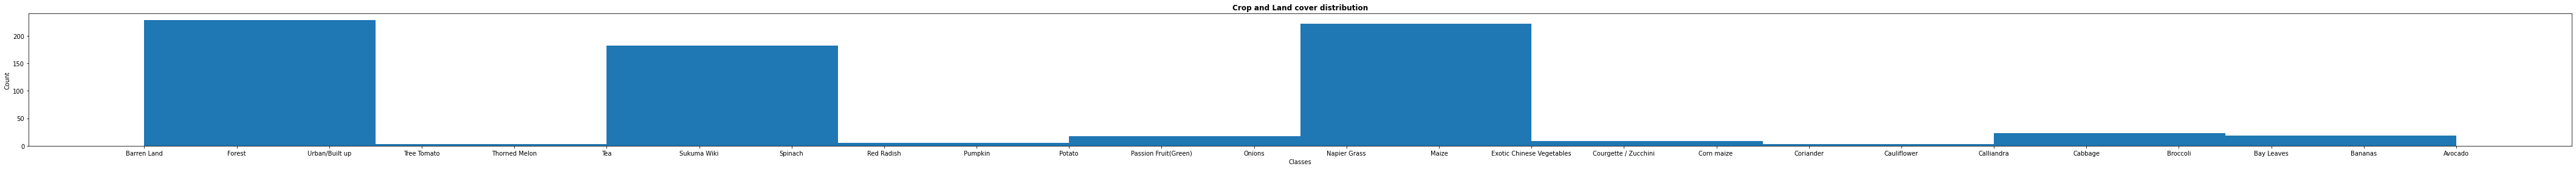

In [ ]:
# plto frequency distribution graph
plt.hist(df1['description'])
plt.rcParams['figure.figsize'] = [75, 4]

plt.xlabel('Classes')
plt.ylabel('Count')
  
plt.title('Crop and Land cover distribution',
          fontweight ="bold")

plt.savefig('crop and land cover distribution.png')  
plt.show()

In [ ]:
# convert to feature collection

features=[]
# Define feature with a geometry and 'name' field from the dataframe
for index, row in df1.iterrows():
    geom=ee.Geometry.Point([row['X'],row['Y']])
    feature = ee.Feature(geom).set({'classification': row['classification']})
    features.append(feature)
fc1 = ee.FeatureCollection(features)

fc1.getInfo()


{'columns': {'classification': 'Integer', 'system:index': 'String'},
 'features': [{'geometry': {'coordinates': [36.687597, -1.072014191],
    'type': 'Point'},
   'id': '0',
   'properties': {'classification': 206},
   'type': 'Feature'},
  {'geometry': {'coordinates': [36.688171, -1.071127095], 'type': 'Point'},
   'id': '1',
   'properties': {'classification': 206},
   'type': 'Feature'},
  {'geometry': {'coordinates': [36.68975733, -1.070010399], 'type': 'Point'},
   'id': '2',
   'properties': {'classification': 206},
   'type': 'Feature'},
  {'geometry': {'coordinates': [36.68426778, -1.071294078], 'type': 'Point'},
   'id': '3',
   'properties': {'classification': 206},
   'type': 'Feature'},
  {'geometry': {'coordinates': [36.69065487, -1.075948721], 'type': 'Point'},
   'id': '4',
   'properties': {'classification': 206},
   'type': 'Feature'},
  {'geometry': {'coordinates': [36.69151065, -1.075750429], 'type': 'Point'},
   'id': '5',
   'properties': {'classification': 206},


In [ ]:
Map.setCenter(36.777911, -1.058634, 14)

#define bbox 
bBox = ee.Geometry.BBox(36.670697, -1.041734, 36.717424, -1.087474)

# Function to mask clouds based on the pixel_qa band of Landsat SR data.

def cloudMaskL8(image):
  qa = image.select('QA_PIXEL')
  # If the cloud bit (5) is set and the cloud confidence (7) is high
  # or the cloud shadow bit is set (3), then it's a bad pixel.
  cloud = qa.bitwiseAnd(1 << 4) \
                  .And(qa.bitwiseAnd(1 << 3)) \
                  .Or(qa.bitwiseAnd(1 << 2))
  # Remove edge pixels that don't occur in all bands
  mask2 = image.mask().reduce(ee.Reducer.min())
  return image.updateMask(cloud.Not()).updateMask(mask2)

# Applies scaling factors.
def applyScaleFactors(image):
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(opticalBands, None, True) \
              .addBands(thermalBands, None, True)

# load processed landsat image

landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate('2022-03-01', '2022-03-31') \
    .map(cloudMaskL8) \
    .map(applyScaleFactors) \
    .median()

visualization = {
  'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
  'min': 0.0,
  'max': 0.3,
}

Map.addLayer(landsat.clip(bBox), visualization)

# calculate indices and add to map
def addIndices(image):
  ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename(['ndvi'])
  ndbi = image.normalizedDifference(['SR_B6', 'SR_B6']).rename(['ndbi'])
  ndwi = image.normalizedDifference(['SR_B3', 'SR_B5']).rename(['ndwi'])
  TCB = image.expression(
    '0.3029 * SR_B2 + 0.2786 * SR_B3 + 0.4733 * SR_B4 + 0.5599 * SR_B5 + 0.508 * SR_B6 + 0.1872 * SR_B7', {
      'SR_B2': image.select('SR_B2'),
      'SR_B3': image.select('SR_B3'),
      'SR_B4': image.select('SR_B4'),
      'SR_B5': image.select('SR_B5'),
      'SR_B6': image.select('SR_B6'),
      'SR_B7': image.select('SR_B7')
    }).rename('TCB')
  bsi = image.expression(
      '(( X + Y ) - (A + B)) /(( X + Y ) + (A + B)) ', {
        'X': image.select('SR_B4'), #red
        'Y': image.select('SR_B6'),  #swi1
        'A': image.select('SR_B5'), # nir
        'B': image.select('SR_B2'), # blue
  }).rename('bsi')
  return image.addBands(ndvi).addBands(ndbi).addBands(ndwi).addBands(bsi)

landsat = addIndices(landsat)

# Function to Normalize Image
def normalize(image):
  bandNames = image.bandNames()
  # Compute min and max of the image
  minDict = image.reduceRegion(**{
    'reducer': ee.Reducer.min(),
    'geometry': bBox,
    'scale': 30,
    'maxPixels': 1e9,
    'bestEffort': True,
    'tileScale': 16
  })
  maxDict = image.reduceRegion(**{
    'reducer': ee.Reducer.max(),
    'geometry': bBox,
    'scale': 30,
    'maxPixels': 1e9,
    'bestEffort': True,
    'tileScale': 16
  })
  mins = ee.Image.constant(minDict.values(bandNames))
  maxs = ee.Image.constant(maxDict.values(bandNames))

  normalized = image.subtract(mins).divide(maxs.subtract(mins))
  return normalized

# Function to Standardize Image

def standardize(image):
  bandNames = image.bandNames()
  # Mean center the data to enable a faster covariance reducer
  # and an SD stretch of the principal components.
  meanDict = image.reduceRegion(**{
    'reducer': ee.Reducer.mean(),
    'geometry': bBox,
    'scale': 30,
    'maxPixels': 1e9,
    'bestEffort': True,
    'tileScale': 16
  })
  means = ee.Image.constant(meanDict.values(bandNames))
  centered = image.subtract(means)

  stdDevDict = image.reduceRegion(**{
    'reducer': ee.Reducer.stdDev(),
    'geometry': bBox,
    'scale': 30,
    'maxPixels': 1e9,
    'bestEffort': True,
    'tileScale': 16
  })
  stddevs = ee.Image.constant(stdDevDict.values(bandNames))

  standardized = centered.divide(stddevs)

  return standardized

landsat= normalize(landsat)
landsat = standardize(landsat)
Map

Map(center=[-1.058634, 36.777911], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox…

In [ ]:
#define training image on landsat
trainLandsatImg = landsat.sampleRegions(**{
    'collection': fc1,
    'properties':["classification"],
    'scale':30,
    'geometries': True
})

#split the data
trainLandsatData = trainLandsatImg.randomColumn()
split_thresh = 0.7

trainLandsat = trainLandsatData.filter(ee.Filter.lt('random', split_thresh))
testLandsat = trainLandsatData.filter(ee.Filter.gte('random',split_thresh))

trainLandsatImg.getInfo()

In [ ]:
train.getInfo()

In [ ]:
test.getInfo()

In [ ]:
trainImage.aggregate_stats('classification').getInfo()

In [ ]:
train.aggregate_stats('classification').getInfo()

In [ ]:
test.aggregate_stats('classification').getInfo()

In [ ]:
# Train a  gradient boosting classifier from the training sample.
classifierLandsat = ee.Classifier.smileGradientTreeBoost(**{
    'numberOfTrees': 100, 
    'shrinkage': 0.005, 
    'samplingRate': 0.7, 
    'maxNodes': 500, 
    'loss': "LeastAbsoluteDeviation", 
    'seed': 1
})

# fit the classifer
bandsLandsat = ['SR_B1',
   'SR_B2',
   'SR_B3',
   'SR_B4',
   'SR_B5',
   'SR_B6',
   'SR_B7',
   'ndvi',
   'ndbi',
   'ndwi',
   'bsi']
trainedClassifierLandsat = classifierLandsat.train(trainLandsat, "classification", bandsLandsat)

# Classify the image.
classifiedLandsat = landsat.classify(trainedClassifierLandsat)


#display the map
#visualize classification
Map.addLayer(classifiedLandsat.clip(bBox),
             {'min': 2, 'max': 206, 
              'palette': [
                          'cadetblue',	
                          'chartreuse',	
                          'chocolate',	
                          'coral',	
                          'cornflowerblue',	
                          'cornsilk',	
                          'crimson',	
                          'cyan',	
                          'darkblue',	
                          'darkcyan',	
                          'darkgoldenrod',	
                          'darkgray',	
                          'darkgreen',	
                          'darkkhaki',	
                          'darkmagenta',
                          'darkolivegreen',	
                          'darkorange',	
                          'darkorchid',	
                          'darkred',	
                          'darksalmon',	
                          'darkseagreen',	
                          'darkslateblue',	
                          'darkslategrey',
                          'deeppink',
                          'lime',
                          'sienna']},
             'classified')
	

Map.setCenter(36.6940605, -1.064604, 14)
Map

Map(bottom=2109787.0, center=[-1.064604, 36.6940605], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
# Get a confusion matrix and overall accuracy for the training sample.
trainAccuracyLandsat = trainedClassifierLandsat.confusionMatrix()
#trainAccuracy.getInfo()


In [ ]:
trainAccuracyLandsat.accuracy().getInfo()

0.9182389937106918

In [ ]:
trainAccuracyLandsat.kappa().getInfo()

0.9048176990063752

In [ ]:
trainAccuracyLandsat.consumersAccuracy().getInfo()

In [ ]:
trainAccuracyLandsat.producersAccuracy().getInfo()

In [ ]:
#classify test set
testClassifierLandsat = classifierLandsat.train(testLandsat, "classification", bandsLandsat)

In [ ]:
# Get a confusion matrix and overall accuracy for the training sample.
testAccuracyLandsat = testClassifierLandsat.confusionMatrix()
#testAccuracy.getInfo()


In [ ]:
testAccuracyLandsat.accuracy().getInfo()

0.9234042553191489

In [ ]:
testAccuracyLandsat.kappa().getInfo()

0.9101567478017076

In [ ]:
testAccuracy.consumersAccuracy().getInfo()

In [ ]:
testAccuracy.producersAccuracy().getInfo()

In [ ]:
# The Sentinel Dataset
S2= ee.ImageCollection("COPERNICUS/S2_HARMONIZED")

def maskS2clouds(image):
  qa = image.select('QA60')


  # Bits 10 and 11 are clouds and cirrus, respectively
  cloudBitMask= 1<<10
  cirrusBitMask = 1<<11
  #setting both flags to zero to indicate clear conditions
  mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
      .And(qa.bitwiseAnd(cirrusBitMask).eq(0))

  return image.updateMask(mask).divide(10000)

#Maping the fucntion over an epoch

image_S2 = ee.ImageCollection("COPERNICUS/S2").filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
                      .filterDate('2022-01-01', '2022-03-31') \
                      .map(maskS2clouds) \
                      .median()
rgbVis= {
   'min': 0.004,
   'max':0.39,
   'bands': ['B11', 'B8', 'B4']
 }


# calculate indices and add to map
def addIndices(image):
  ndvi = image.normalizedDifference(['B8', 'B4']).rename(['ndvi'])
  ndbi = image.normalizedDifference(['B6', 'B6']).rename(['ndbi'])
  ndwi = image.normalizedDifference(['B8', 'B12']).rename(['ndwi'])
  bsi = image.expression(
      '(( X + Y ) - (A + B)) /(( X + Y ) + (A + B)) ', {
        'X': image.select('B11'), #red
        'Y': image.select('B4'),  #swi1
        'A': image.select('B8'), # nir
        'B': image.select('B2'), # blue
  }).rename('bsi')
  return image.addBands(ndvi).addBands(ndbi).addBands(ndwi).addBands(bsi)

image_S2 = addIndices(image_S2)

Map.setCenter(36.6940605, -1.064604, 14)
#define bbox 
bBox = ee.Geometry.BBox(36.670697, -1.041734, 36.717424, -1.087474)
Map.addLayer(image_S2.clip(bBox))
Map

In [ ]:
#define training image on sentinel 2
trainImgSent2 = image_S2.sampleRegions(**{
    'collection': fc1,
    'properties':["classification"],
    'scale':30,
    'geometries': True
})

#split the data
trainImgSent2 = trainImgSent2.randomColumn()
split_thresh = 0.7

trainSent2 = trainImgSent2.filter(ee.Filter.lt('random', split_thresh))
testSent2 = trainImgSent2.filter(ee.Filter.gte('random',split_thresh))

trainSent2.getInfo()

In [ ]:
testSent2.aggregate_stats('classification').getInfo()

In [ ]:
# Train a  gradient boosting classifier from the training sample.
classifierSent2 = ee.Classifier.smileGradientTreeBoost(**{
    'numberOfTrees': 100, 
    'shrinkage': 0.005, 
    'samplingRate': 0.7, 
    'maxNodes': 500, 
    'loss': "LeastAbsoluteDeviation", 
    'seed': 1
})

# fit the classifer
bandsSent2 = ['B1',
   'B2',
   'B3',
   'B4',
   'B5',
   'B6',
   'B7',
   'B8',
   'B8A',
   'B9',
   'B10',
   'B11',
   'B12',
   'ndvi',
   'ndbi',
   'ndwi',
   'bsi']
trainedClassifierSent2 = classifierSent2.train(trainSent2, "classification", bandsSent2)

# Classify the image.
classifiedSent2 = image_S2.classify(trainedClassifierSent2)


#display the map
#visualize classification
Map.addLayer(classifiedSent2.clip(bBox),
             {'min': 2, 'max': 206, 
              'palette': [
                          '#5F9EA0',	
                          '#7FFF00',	
                          '#D2691E',	
                          '#FF7F50',	
                          '#6495ED',	
                          '#FFF8DC',	
                          '#DC143C',	
                          '#00FFFF',	
                          '#00008B',	
                          '#008B8B',	
                          '#B8860B',	
                          '#A9A9A9',	
                          '#006400',	
                          '#BDB76B',	
                          '#8B008B',
                          '#556B2F',	
                          '#FF8C00',	
                          '#9932CC',	
                          '#8B0000',	
                          '#E9967A',	
                          '#8FBC8F',	
                          '#483D8B',	
                          '#2F4F4F',
                          '#FF1493',
                          '#00FF00',
                          '#A0522D']},
             'classified')
	

Map.setCenter(36.6940605, -1.064604, 14)
Map

Map(bottom=2109856.0, center=[-1.064604, 36.6940605], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
# Get a confusion matrix and overall accuracy for the training sample.
trainAccuracySent2 = trainedClassifierSent2.confusionMatrix()
trainAccuracySent2.getInfo()


In [ ]:
trainAccuracySent2.accuracy().getInfo()

0.9223107569721115

In [ ]:
trainAccuracySent2.kappa().getInfo()

0.9005787515502274

In [ ]:
#classify test set
testClassifierSent2 = classifierSent2.train(testSent2, "classification", bandsSent2)

In [ ]:
# Get a confusion matrix and overall accuracy for the training sample.
testAccuracySent2 = testClassifierSent2.confusionMatrix()
#testAccuracy.getInfo()


In [ ]:
testAccuracySent2.accuracy().getInfo()

0.8990825688073395

In [ ]:
testAccuracySent2.kappa().getInfo()

0.9359581287306301

In [ ]:
areaImage = ee.Image.pixelArea().divide(1e6).addBands(classified)

# Calculate Area by Class
# Using a Grouped Reducer
areas = areaImage.reduceRegion(**{
      'reducer': ee.Reducer.sum().group(**{
      'groupField': 1,
      'groupName': 'classification',
    }),
    'geometry': bBox,
    'scale': 30
    })

classAreas = ee.List(areas.get('groups'))
print(classAreas)

# export as csv
mytask = ee.batch.Export.table.toDrive(collection=classAreas, 
                                       folder='/content/drive/MyDrive/ content drive MyDrive', 
                                       description='crop_areas_rf', 
                                       fileFormat='CSV')

In [ ]:
# define legend dictionary

ee_class_table = """

Value  Color Description
2 cadetblue Avocado
6 chartreuse  Bay Leaves
13  chocolate Calliandra
24  coral Coriander
17  cornflowerblue  Cauliflower
3 cornsilk  Bananas 
27  crimson Courgette 
33  cyan  Exotic chinese vegetables
10  darkblue  Broccoli 
103 darkcyan  Spinach 
115 darkgoldenrod Thorned Melon
25  darkgray  Corn Maize
76  darkgreen Passion Fruit
12  darkkhaki Cabbage 
89  darkmagenta Pumpkin 
70  darkolivegreen  Onions 
118 darkorange  Tree tomato
93  darkorchid  Red Radish
87  darkred Potato
108 darksalmon  Sukuma Wiki
57  darkseagreen  Maize
67  darkslateblue Napier Grass
113 darkslategray Tea
200 deeppink  Urban/ Built Area
203 lime  Forestland
206 sienna  Barren
"""

legend_dict = geemap.legend_from_ee(ee_class_table)
Map.add_legend(legend_title="Crop and Land Classification", legend_dict=legend_dict)
Map.add_legend(legend_dict=legend_dict)
Map

list index out of range


Map(bottom=2109856.0, center=[-1.064604, 36.6940605], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
classified.getInfo()

{'bands': [{'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 2147483647,
    'min': -2147483648,
    'precision': 'int',
    'type': 'PixelType'},
   'id': 'classification'}],
 'type': 'Image'}

In [ ]:
dataset.getInfo()

{'bands': [{'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 13.595968790787326,
    'min': -4.899155976158784,
    'precision': 'double',
    'type': 'PixelType'},
   'id': 'SR_B1'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 13.709589041324502,
    'min': -4.996635899478313,
    'precision': 'double',
    'type': 'PixelType'},
   'id': 'SR_B2'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 14.982056153795222,
    'min': -5.625856198588049,
    'precision': 'double',
    'type': 'PixelType'},
   'id': 'SR_B3'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 14.988747133610564,
    'min': -5.543953261893737,
    'precision': 'double',
    'type': 'PixelType'},
   'id': 'SR_B4'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 17.475650783548808,
    'min': -10.724361694846278,
    'precisi

In [ ]:
# ndvi properties in dataset
'''
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 4.287969859172442,
    'min': -7.6952461046816225,
    'precision': 'double',
    'type': 'PixelType'},
   'id': 'ndvi'},
'''
NDVI = dataset.select('ndvi')
Map.addLayer(NDVI.clip(bBox), vis_params = {'min': -7.6952461046816225, 
                                            'max': 4.287969859172442,
                                            'palette':[
                                                       'darkred',
                                                       'red',
                                                       'yellow',
                                                       'limegreen',
                                                       'darkgreen'
                                            ]})
Map

Map(bottom=2109865.0, center=[-1.064582599571565, 36.69407844543458], controls=(WidgetControl(options=['positi…

In [ ]:
baringo = ee.Geometry.BBox(35.528285, 0.170590, 35.840163, -0.097081)

# Function to mask clouds based on the pixel_qa band of Landsat SR data.

def cloudMaskL8(image):
  qa = image.select('QA_PIXEL')
  # If the cloud bit (5) is set and the cloud confidence (7) is high
  # or the cloud shadow bit is set (3), then it's a bad pixel.
  cloud = qa.bitwiseAnd(1 << 4) \
                  .And(qa.bitwiseAnd(1 << 3)) \
                  .Or(qa.bitwiseAnd(1 << 2))
  # Remove edge pixels that don't occur in all bands
  mask2 = image.mask().reduce(ee.Reducer.min())
  return image.updateMask(cloud.Not()).updateMask(mask2)

# Applies scaling factors.
def applyScaleFactors(image):
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(opticalBands, None, True) \
              .addBands(thermalBands, None, True)

# load processed landsat image

june = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate('2021-06-01', '2022-06-30') \
    .map(cloudMaskL8) \
    .map(applyScaleFactors) \
    .median()

visualization = {
  'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
  'min': 0.0,
  'max': 0.3,
}

Map.addLayer(june.clip(baringo), visualization, 'june')

# calculate indices and add to map
def addIndices(image):
  ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename(['ndvi'])
  ndbi = image.normalizedDifference(['SR_B6', 'SR_B6']).rename(['ndbi'])
  ndwi = image.normalizedDifference(['SR_B3', 'SR_B5']).rename(['ndwi'])
  TCB = dataset.expression(
    '0.3029 * SR_B2 + 0.2786 * SR_B3 + 0.4733 * SR_B4 + 0.5599 * SR_B5 + 0.508 * SR_B6 + 0.1872 * SR_B7', {
      'SR_B2': image.select('SR_B2'),
      'SR_B3': image.select('SR_B3'),
      'SR_B4': image.select('SR_B4'),
      'SR_B5': image.select('SR_B5'),
      'SR_B6': image.select('SR_B6'),
      'SR_B7': image.select('SR_B7')
    }).rename('TCB')
  bsi = image.expression(
      '(( X + Y ) - (A + B)) /(( X + Y ) + (A + B)) ', {
        'X': image.select('SR_B4'), #red
        'Y': image.select('SR_B6'),  #swi1
        'A': image.select('SR_B5'), # nir
        'B': image.select('SR_B2'), # blue
  }).rename('bsi')
  return image.addBands(ndvi).addBands(ndbi).addBands(ndwi).addBands(bsi)

june = addIndices(june)

# Function to Normalize Image
def normalize(image):
  bandNames = image.bandNames()
  # Compute min and max of the image
  minDict = image.reduceRegion(**{
    'reducer': ee.Reducer.min(),
    'geometry': bBox,
    'scale': 30,
    'maxPixels': 1e9,
    'bestEffort': True,
    'tileScale': 16
  })
  maxDict = image.reduceRegion(**{
    'reducer': ee.Reducer.max(),
    'geometry': bBox,
    'scale': 30,
    'maxPixels': 1e9,
    'bestEffort': True,
    'tileScale': 16
  })
  mins = ee.Image.constant(minDict.values(bandNames))
  maxs = ee.Image.constant(maxDict.values(bandNames))

  normalized = image.subtract(mins).divide(maxs.subtract(mins))
  return normalized

# Function to Standardize Image

def standardize(image):
  bandNames = image.bandNames()
  # Mean center the data to enable a faster covariance reducer
  # and an SD stretch of the principal components.
  meanDict = image.reduceRegion(**{
    'reducer': ee.Reducer.mean(),
    'geometry': bBox,
    'scale': 30,
    'maxPixels': 1e9,
    'bestEffort': True,
    'tileScale': 16
  })
  means = ee.Image.constant(meanDict.values(bandNames))
  centered = image.subtract(means)

  stdDevDict = image.reduceRegion(**{
    'reducer': ee.Reducer.stdDev(),
    'geometry': bBox,
    'scale': 30,
    'maxPixels': 1e9,
    'bestEffort': True,
    'tileScale': 16
  })
  stddevs = ee.Image.constant(stdDevDict.values(bandNames))

  standardized = centered.divide(stddevs)

  return standardized

june= normalize(june)
june = standardize(june)


# validate with Baringo

#baringo = ee.Geometry.BBox(35.528285, 0.170590, 35.840163, -0.097081)

# Classify the image.
classified = june.classify(trainedClassifier)

#display the map
#visualize classification
Map.addLayer(classified.clip(baringo),
             {'min': 10, 'max': 206,
              'palette': [
                          'cadetblue',
                          'chartreuse',
                          'chocolate',
                          'coral',
                          'cornflowerblue',
                          'cornsilk',
                          'crimson',
                          'cyan',
                          'darkblue',
                          'darkcyan',
                          'darkgoldenrod',
                          'darkgray',
                          'darkgreen',
                          'darkkhaki',
                          'darkmagenta',
                          'darkolivegreen',
                          'darkorange',
                          'darkorchid',
                          'darkred',
                          'darksalmon',
                          'darkseagreen',
                          'darkslateblue',
                          'darkslategrey']},
             'classified')

Map

Map(bottom=524398.0, center=[0.0652313091502137, 35.684623718261726], controls=(WidgetControl(options=['positi…

In [ ]:
# define legend dictionary
legend_dict = {
    'Avocado': 'cadetblue',                  #2          
    'Bay Leaves':  'chartreuse',             #6        
    'Calliandra': 'chocolate',               #13        
    'Coriander': 'coral',                    #24        
    'Cauliflower': 'cornflowerblue',         #17        
    'Bananas': 'cornsilk',                   #3         
    'Courgette': 'crimson',                  #27        
    'Exotic Chinese Vegetables': 'cyan',     #33        
    'Broccoli': 'darkblue',                  #10        
    'Spinach': 'darkcyan',                   #103      
    'Thorned Melon': 'darkgoldenrod',	       #115      
    'Corn Maize': 'darkgray',	               #25       
    'Passion Fruit': 'darkgreen',	           #76       
    'Cabbage': 'darkkhaki',                  #12       
    'Pumpkin': 'darkmagenta',                #89       
    'Onions': 'darkolivegreen',	             #70       
    'Tree Tomato': 'darkorange',             #118      
    'Red Radish': 'darkorchid',              #93       
    'Potato': 'darkred',                     #87      
    'Sukuma Wiki': 'darksalmon',             #108     
    'Maize': 'darkseagreen',                 #57      
    'Napier Grass': 'darkslateblue',         #67      
    'Tea':'darkslategray',                    #113
    'Urban or Built up area': 'deeppink',             #200
    'Agriculture Land': 'sienna',                   #201
    'Forest Land':'lime',                  #203
    'Barren Land':'olive',                #206 
}
	
Map.add_legend(legend_dict=legend_dict)
Map